### **Context**

This first notebook is part of a bigger project, and is concerned with the **data assemblage**, **cleaning process** and **descriptives**. The project itself is about investigating examinee level predictors of test taking disengagement on the PISA. 

The parameters estimation itself of the IRTree model was conducted within using the Monte Carlo Markov chain bayesian approach is SAS.

The Programme for International Student Assessment (PISA) is a triennial evaluation aimed at gauging the abilities and skills of students approaching the end of compulsory education in solving real-world challenges (OECD, PISA 2022). Participating students from various countries are tested in three core
disciplines: Mathematics, Science, and Reading, with an innovative discipline every cycle (e.g., critical thinking). They take a questionnaire at the end of the test that collect background characteristics. 

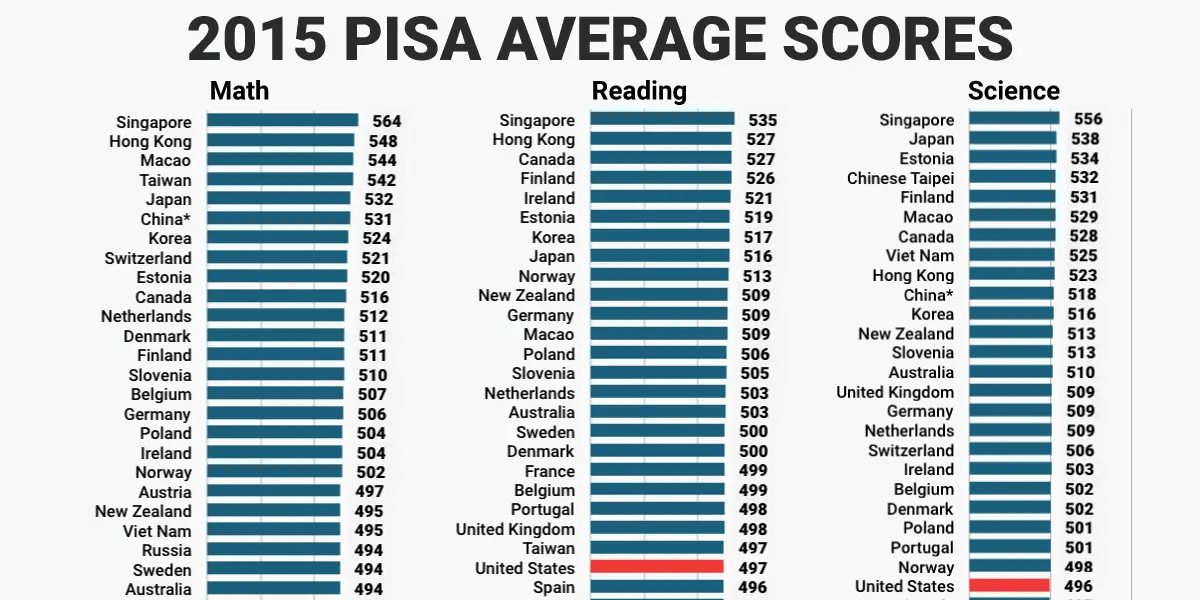

Approximately 690,000 students representing 81 participating countries/economies completed PISA 2022, the 8th and most recent cycle of the assessment that had critical thinking as an optional domain. Each of these students took test forms that tested at least 2 of the four disciplines 



### **The dataset constitution**
There are 3 main datasets released by the PISA that I used in this project:

- The first is the final MASSIVE [cognitive dataset](https://www.oecd.org/en/data/datasets/pisa-2022-database.html#data) (23.2GB) that contains for each of the 690,000 students their item raw and scored responses on each of the items for the test forms received and other identification variables. The total number of variables was 5023. For the computer based test for instance there were 196 items Reading, 115 Science items and 234 mathematics items (545).

- The second is the excel codebook containing sheets for each discipline in its computer based form (CBA) and paper based form (PBA).

- The last is also a big [dataset](https://www.oecd.org/en/data/datasets/pisa-2022-database.html#data) (4GB) containing student responses to the background questionnaire.


For this project, I my focus was on the science discipline for students in the USA. So I had to extract the relevant part of the datasets to build my own dataset.

**DASK** \
The data downloaded from [here](https://www.oecd.org/en/data/datasets/pisa-2022-database.html) is a SAS dataset (sas7bdat file). Therefore I transformed it to csv in SAS and then read it in here using the `dask` library. I used `pandas` first, but it was too slow. 

DASK has the advantage of running operations in parallel within a pipeline, allowing tasks to be executed efficiently. Most common data methods used with PANDAS are compatible with Dask (no need to learn new set of commands, pd is operating under the hood), and it uses lazy evaluation, meaning computations are only performed when an actual output is needed.

A great description can be read [here](https://saturncloud.io/blog/what-is-dask/)

In [376]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [377]:
# Specify a directory
import os as os

print(os.getcwd())

os.chdir(r"C:\Users\mehoujm\Downloads")

C:\Users\mehoujm\Downloads


In [378]:
os.getcwd()

'C:\\Users\\mehoujm\\Downloads'

##### Import the dataset. 

When working with Dask to read large datasets, an issue that often arises is related to memory management. Unlike traditional pandas, Dask doesn't load the entire dataset into memory at once, allowing for scalable processing. 

However, because it processes data in chunks, Dask requires the user to explicitly define the data types of each variable. This is necessary because Dask can't infer data types efficiently across large datasets in a distributed environment, and mismatched or ambiguous data types can lead to inefficiencies or errors during computation. 

Specifying the types upfront ensures smoother, more predictable performance which is what I do in the following snippets of code

In [379]:
# let's first create a list of all the variables

var = pd.read_csv("Variables.csv")  #The file `Variables.csv` contains the list of all vars that I obtained from the codebook

print(len(var)) # get the number of vars
var.head()

5023


,NAME
0,CNT
1,CNTRYID
2,CNTSCHID
3,CNTSTUID
4,CYC


In [380]:
# In the dictionnary I assosiate every var name to the type `object`.
dic_var = {i: "object" for i in var["NAME"] }
len(dic_var)

5023

In [381]:
# Import the dataset
pisa_data = dd.read_csv("PISA_COG_2022.csv", names = var["NAME"], dtype= dic_var, encoding  = "Latin1")

In [96]:
pisa_data["CNT"].head()

0    ALB
1    ALB
2    ALB
3    ALB
4    ALB
Name: CNT, dtype: object

#### Extract the relevant info

Now that the dataset is imported, let's extract the relevant rows.   
We'll extract 
- columns containing identification information. the id variables are:

|   Variable Code | Description                                       |
|-----------------|---------------------------------------------------|
| CNT             | Country Code                                      |
| CNTRYID         | Country Identifier                                |
| CNTSCHID        | International School ID                           |
| CNTSTUID        | International Student ID                          |
| CYC             | Assessment Cycle                                  |
| NatCen          | National Center Identifier                        |
| STRATUM         | Sampling Stratum within a country                 |
| SUBNATIO        | Sub-national Region                               |
| REGION          | Geographic Region                                 |
| OECD            | OECD Membership Indicator                         |
| ADMINMODE       | Mode of Administration (e.g., paper, computer)    |
| LANGTEST_COG    | Language of the Cognitive Test                    |
| Option_CT       | Country-specific option related to test settings  |
| Option_FL       | Country-specific option related to fluency        |
| Option_UH       | Country-specific option related to understanding  |
| BOOKID          | Booklet or form Identifier                        |


- columns containing scored science items

There are a total of 115 science items, 105 of which are dichotomous and 10 of which are polytomous.


- columns containing total time for every science item (We need timing information on each item because it is vital in how we operationalize test taking disengagement: refer to the paper associated (Mehou et al., 2024)


In [42]:
# The id vars are the first 16 rows of var 
id_vars = var[:16]
id_vars.head()

,NAME
0,CNT
1,CNTRYID
2,CNTSCHID
3,CNTSTUID
4,CYC


In [43]:
# The science vars
science_vars = pd.read_csv("science_vars.csv", names = ["vars"]) # `science_vars.csv contains the science vars
science_vars

,vars
0,CS408Q01S
1,DS408Q03C
2,CS408Q04S
3,CS408Q05S
4,CS413Q06S
...,...
110,CS638Q04S
111,CS615Q07S
112,CS615Q01S
113,CS615Q02S


For some reason in the dataset, the time variables all start with `CS` and end with `TT` for every science item in `science_vars`, even when the variable doesn't start with `CS` and starts with `DS` for instance.

In [44]:
# I use a regular expression to extract anything that starts with at least one of C,S or D and ends with S or C; 
# but I only capture the middle part [0-9Q]+ .
science_time_vars = "CS" + science_vars["vars"].str.extract(r"[CSD]+([0-9Q]+)[SC]+")[0] + "TT" 
science_time_vars.head()

0    CS408Q01TT
1    CS408Q03TT
2    CS408Q04TT
3    CS408Q05TT
4    CS413Q06TT
Name: 0, dtype: object

In [45]:
# Create the list that contains all the vars to be extracted (id_vars & science vars & sience timing vars) 
# by concatenating the three pd.Series

extract_vars = pd.concat( [id_vars["NAME"], science_vars["vars"], science_time_vars], ignore_index = True, axis = 0).to_list()
extract_vars

['CNT',
 'CNTRYID',
 'CNTSCHID',
 'CNTSTUID',
 'CYC',
 'NatCen',
 'STRATUM',
 'SUBNATIO',
 'REGION',
 'OECD',
 'ADMINMODE',
 'LANGTEST_COG',
 'Option_CT',
 'Option_FL',
 'Option_UH',
 'BOOKID',
 'CS408Q01S',
 'DS408Q03C',
 'CS408Q04S',
 'CS408Q05S',
 'CS413Q06S',
 'CS413Q04S',
 'CS413Q05S',
 'CS635Q01S',
 'CS635Q02S',
 'DS635Q03C',
 'CS635Q04S',
 'DS635Q05C',
 'CS604Q02S',
 'DS604Q04C',
 'DS625Q01C',
 'CS625Q02S',
 'CS625Q03S',
 'CS626Q01S',
 'CS626Q02S',
 'CS626Q03S',
 'DS425Q03C',
 'CS425Q05S',
 'CS425Q02S',
 'DS425Q04C',
 'CS438Q01S',
 'CS438Q02S',
 'DS438Q03C',
 'CS608Q01S',
 'CS608Q02S',
 'CS608Q03S',
 'DS608Q04C',
 'DS643Q03C',
 'CS643Q01S',
 'CS643Q02S',
 'CS643Q04S',
 'DS643Q05C',
 'DS610Q01C',
 'CS610Q02S',
 'CS466Q01S',
 'CS466Q07S',
 'CS256Q01S',
 'DS326Q01C',
 'DS326Q02C',
 'CS326Q03S',
 'CS326Q04S',
 'CS602Q01S',
 'CS602Q02S',
 'DS602Q03C',
 'CS602Q04S',
 'CS603Q01S',
 'DS603Q02C',
 'CS603Q03S',
 'CS603Q04S',
 'CS603Q05S',
 'CS657Q01S',
 'CS657Q02S',
 'CS657Q03S',
 'DS657Q

In [102]:
# The extraction of USA examinees
bool = pisa_data["CNT"] == "USA"
pisa_science_usa = pisa_data.loc[bool, extract_vars]

In [104]:
# Exportation 
pisa_science_usa.to_csv("pisa_science_usa.csv", index=False, single_file=True)

['C:\\Users\\mehoujm\\Downloads\\pisa_science_usa.csv']

One thing to note is that given the design of the PISA, **NOT ALL USA STUDENTS** received test forms that have science items within (for more info about the design, mehou et al., 2024 or the PISA 2022 technical report [here](https://www.oecd.org/en/about/programmes/pisa/pisa-data.html#methodology). 

Because of that, we have to further narrow the extraction by filtering by specific test form numbers (those that contain science items). But, I do not need DASK anymore, since the size and manageable and I don't want lazy functions. I'll therefore work on the exported dataset

Essentially the forms concerned are the following: form 13 through 36 and  57 through 66

In [271]:
pisa_science_usa1 = pd.read_csv("pisa_science_usa.csv") #Importing previously exported csv file

pisa_science_usa2 = pisa_science_usa1[pisa_science_usa1["BOOKID"].isin(list(range(13,37)) + list(range(57,67)))] # filtering out unnecessary forms
pisa_science_usa2.shape

(2201, 246)

###  **Explore extracted dataset**

I extracted multiple id vars previously, but from here on, I only need one: The `CNTSTUID` which is unique student identifier internationally. In other words with that number, we can identify uniquely a student without knowing anything else among all students who took the PISA test in the world. 

I will therefore extract the only the `CNTSTUID` variable and the 115 science item responses and their timing corresponding variables.

In [272]:
# We have 115 variables and their respective timing plus one id variable. The total should be 231 variables
needed_vars = ["CNTSTUID"] + extract_vars[16:246] 
len(needed_vars)

231

In [273]:
# relevant dataset
pisa_usa_need = pisa_science_usa2.loc[:, needed_vars]

pisa_usa_need.columns[[115,230]] # check whether the 115th and 230th elements are respectively 
                                #the item response and timing variable of same item

Index(['CS615Q05S', 'CS615Q05TT'], dtype='object')

In [274]:
pisa_usa_need.to_csv("pisa_science_need1.csv", index=False)

In [275]:
pisa_usa_need.tail()

,CNTSTUID,CS408Q01S,DS408Q03C,CS408Q04S,CS408Q05S,CS413Q06S,CS413Q04S,CS413Q05S,CS635Q01S,CS635Q02S,...,CS607Q01TT,CS607Q02TT,CS607Q03TT,CS638Q01TT,CS638Q02TT,CS638Q04TT,CS615Q07TT,CS615Q01TT,CS615Q02TT,CS615Q05TT
4534,84008120,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
4539,84008130,.,.,.,.,.,.,.,.,.,...,13834,34113,153926,60756,42490,.,.,.,.,.
4544,84008143,0,0,0,0,0,1,1,1,1,...,.,.,.,.,.,.,.,.,.,.
4545,84008146,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
4547,84008148,1,0,0,0,1,1,1,1,1,...,.,.,.,.,.,.,.,.,.,.


In [276]:
# get the unique values of item responses and different timing vars to get a sense or weird values...
distr = []
for i in range(1,231):
    count = pisa_usa_need.iloc[:,i].unique().tolist()
    distr += count # I stack in one list all the unique values
distr = pd.Series(distr) # Tranform in a Series to be able to use the str accessor on it.

In [277]:
# I want every element that is not a number ([^0-9]+). I'll explore numbers later.
distr.str.extract(r"([^0-9]+)")[0].unique()

array(['.', nan, 'R', 'M', 'I'], dtype=object)

##### Missing data types
The PISA documentation has the following definitions for the coding observed above:

- *System Missing (nan)/Blank(dot)* – used to indicate that the respondent was not presented the question
according to the survey design or ended the questionnaire early, or data loss.

- *No Response (.M/99)* – used to indicate the respondent had an opportunity to answer the question but did
not respond. For derived variables, it is often used as an indicator for all different types of missing
data.

- *Invalid (.I/98)* – used to indicate that the response was not appropriate or contradicted a prior response,
e.g., the response to a question asking for a percentage was greater than 100.

- *Not Applicable (.N/97)* – used to indicate in the questionnaire that the question was not asked by design
or could not be determined due to a printing problem or torn booklet, or due to within-construct
matrix sampling design. **In the cognitive data, it is used to indicate that the question was
dropped/deleted during item calibration and not used during scaling**

- *Valid Skip (.V/95)* – used in **the questionnaire data** to indicate that the question was not answered because
a response to an earlier question directed the respondent to skip the question

- *Not Reached (.R/96* – used in the cognitive scored variables to indicate that a student was unlikely to
have seen the question and the response should be treated as such.




I will recode all these values to one missing variable.

In [278]:
# Recode to missing R, M and I
def to_missing(cell):
    if cell in ['.', 'R', 'M', 'I']:
        cell = np.nan
        return cell
    else:
        return cell


pisa_usa_need_cleaned = pisa_usa_need.map(to_missing)

In [279]:
# Transform every variable to float type 
pisa_float = pisa_usa_need_cleaned.astype("float")
pisa_float.tail()

,CNTSTUID,CS408Q01S,DS408Q03C,CS408Q04S,CS408Q05S,CS413Q06S,CS413Q04S,CS413Q05S,CS635Q01S,CS635Q02S,...,CS607Q01TT,CS607Q02TT,CS607Q03TT,CS638Q01TT,CS638Q02TT,CS638Q04TT,CS615Q07TT,CS615Q01TT,CS615Q02TT,CS615Q05TT
4534,84008120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4539,84008130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13834.0,34113.0,153926.0,60756.0,42490.0,NaN,NaN,NaN,NaN,NaN
4544,84008143.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4545,84008146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547,84008148.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [280]:
pisa_float.reset_index(inplace = True, drop=True)
pisa_float.tail()

,CNTSTUID,CS408Q01S,DS408Q03C,CS408Q04S,CS408Q05S,CS413Q06S,CS413Q04S,CS413Q05S,CS635Q01S,CS635Q02S,...,CS607Q01TT,CS607Q02TT,CS607Q03TT,CS638Q01TT,CS638Q02TT,CS638Q04TT,CS615Q07TT,CS615Q01TT,CS615Q02TT,CS615Q05TT
2196,84008120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2197,84008130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13834.0,34113.0,153926.0,60756.0,42490.0,NaN,NaN,NaN,NaN,NaN
2198,84008143.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2199,84008146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2200,84008148.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, let's explore the numeric values to check if they make sense

In [281]:
pisa_float["CS408Q01S"].unique().tolist()[:3]

[nan, 1.0, 0.0]

In [282]:
# Explore the values of every variable 

polytomous_weird_items = [] # A list that will store polytomous items that have weird values (other than 0,1,2)
polytomous_items = []       # A list that will store "normal" polytomous items
dichotomous_weird_items = [] # A list that will store dichotomous items that have weird values (other than 0,1)
dichotomous_items = []       # dichotomous items (0,1)
surprise_me = []             # Anything that doesn't fall within the above

for i in pisa_float.iloc[:,1:116].columns:
    freq = pisa_float[i].value_counts(dropna = True)
    if freq.shape[0] > 2 and sorted(freq.index.tolist()) != [0.0, 1.0, 2.0]:
        polytomous_weird_items.append(freq.index.name)
    elif freq.shape[0] > 2 and sorted(freq.index.tolist()) == [0.0, 1.0, 2.0] :
        polytomous_items.append(freq.index.name)
    elif freq.shape[0] == 2 and sorted(freq.index.tolist()) != [0.0, 1.0]:
        dichotomous_weird_items.append(freq.index.name)
    elif freq.shape[0] == 2 and sorted(freq.index.tolist()) == [0.0, 1.0]:
        dichotomous_items.append(freq.index.name)
    elif freq.shape[0] < 2:
        print (freq)
        surprise_me.append(freq.index.name)   

Check weird items

In [283]:
polytomous_weird_items

['DS438Q03C', 'DS657Q04C']

In [284]:
# look closer
[pisa_float[i].value_counts(dropna = False) for i in polytomous_weird_items]

[DS438Q03C
 NaN     1519
 1.0      394
 11.0     168
 12.0     120
 Name: count, dtype: int64,
 DS657Q04C
 NaN     1566
 1.0      321
 11.0     156
 21.0     127
 12.0      31
 Name: count, dtype: int64]

`DS438Q03C` and `DS657Q04C` are weird items because of the unexpected weird values `11`, `12`, `21`. We'll investigate them later. 

In [285]:
polytomous_items

['CS635Q01S',
 'CS635Q04S',
 'DS635Q05C',
 'CS634Q02S',
 'DS629Q01C',
 'DS498Q04C',
 'DS605Q04C',
 'CS645Q01S',
 'DS607Q03C']

In [286]:
[pisa_float[i].value_counts(dropna = False) for i in polytomous_items]

[CS635Q01S
 NaN    1512
 1.0     335
 2.0     187
 0.0     167
 Name: count, dtype: int64,
 CS635Q04S
 NaN    1519
 0.0     236
 2.0     233
 1.0     213
 Name: count, dtype: int64,
 DS635Q05C
 NaN    1531
 0.0     515
 2.0      79
 1.0      76
 Name: count, dtype: int64,
 CS634Q02S
 NaN    1496
 0.0     367
 1.0     257
 2.0      81
 Name: count, dtype: int64,
 DS629Q01C
 NaN    1524
 2.0     354
 0.0     182
 1.0     141
 Name: count, dtype: int64,
 DS498Q04C
 NaN    1482
 2.0     430
 0.0     214
 1.0      75
 Name: count, dtype: int64,
 DS605Q04C
 NaN    1575
 0.0     310
 2.0     231
 1.0      85
 Name: count, dtype: int64,
 CS645Q01S
 NaN    1547
 2.0     322
 0.0     212
 1.0     120
 Name: count, dtype: int64,
 DS607Q03C
 NaN    1512
 0.0     364
 2.0     236
 1.0      89
 Name: count, dtype: int64]

There seems to be no problem with those as espected

In [345]:
dichotomous_items[:5]

['CS408Q01S', 'DS408Q03C', 'CS408Q04S', 'CS408Q05S', 'CS413Q06S']

In [288]:
print(surprise_me) # Nothing surprising

[]


Now, let's investigate the weird values in polytomous weird 

After reading the codebook...\
-  `DS438Q03C` is a human coded variable (for an open ended response) such that:

    - the values of `12` and `11` are `full credit` codes (see codebook).
      
    - the value of `1` is `No credit`

Therefore, we need to recode `1` as `0` (`No credit`) and `12` and `11` as `1` (`Full credit`) just like other dichotomous items.
  
- `DS657Q04C` is a human coded variable (for an open ended response) such that:
     -  `1` is `No credit`

    -  `12` and `11` are `partial credit` codes

    -  `21` is `full credit`  

Therefore we need to recode `1` as `0`,  `12` and `11` as `1` and and `21` as `2` to correspond other polytomous items

In [289]:
pisa_float1 = pisa_float.copy()

In [306]:
pisa_float1["DS438Q03C"] = (np.where(pisa_float["DS438Q03C"] == 1, 0, 
                                   np.where(pisa_float["DS438Q03C"].isin([11,12]),1, np.nan))
                         )

In [307]:
pisa_float1["DS657Q04C"] = (np.where(pisa_float["DS657Q04C"] == 1, 0, 
                                   np.where(pisa_float["DS657Q04C"].isin([11,12]),1,
                                            np.where(pisa_float["DS657Q04C"] == 21 ,2, np.nan)))
                         )

In [317]:
# Check reassignment for DS438Q03C
res = pd.concat([pisa_float1["DS438Q03C"], pisa_float["DS438Q03C"]], axis = 1)
res.columns = ["1", "2"]
res.value_counts(["1", "2"])

1    2   
0.0  1.0     394
1.0  11.0    168
     12.0    120
Name: count, dtype: int64

In [318]:
# Check reassignment for DS657Q04C
res1 = pd.concat([pisa_float1["DS657Q04C"], pisa_float["DS657Q04C"]], axis = 1)
res1.columns = ["1", "2"]
res1.value_counts(["1", "2"])

1    2   
0.0  1.0     321
1.0  11.0    156
2.0  21.0    127
1.0  12.0     31
Name: count, dtype: int64

In [348]:
# Get new values for lists after above

polytomous_weird_items = [] # A list that will store polytomous items that have weird values (other than 0,1,2)
polytomous_items = []       # A list that will store "normal" polytomous items
dichotomous_weird_items = [] # A list that will store dichotomous items that have weird values (other than 0,1)
dichotomous_items = []       # dichotomous items (0,1)
surprise_me = []             # Anything that doesn't fall within the above

for i in pisa_float1.iloc[:,1:116].columns:
    freq = pisa_float1[i].value_counts(dropna = True)
    if freq.shape[0] > 2 and sorted(freq.index.tolist()) != [0.0, 1.0, 2.0]:
        polytomous_weird_items.append(freq.index.name)
    elif freq.shape[0] > 2 and sorted(freq.index.tolist()) == [0.0, 1.0, 2.0] :
        polytomous_items.append(freq.index.name)
    elif freq.shape[0] == 2 and sorted(freq.index.tolist()) != [0.0, 1.0]:
        dichotomous_weird_items.append(freq.index.name)
    elif freq.shape[0] == 2 and sorted(freq.index.tolist()) == [0.0, 1.0]:
        dichotomous_items.append(freq.index.name)
    elif freq.shape[0] < 2:
        print (freq)
        surprise_me.append(freq.index.name)   

In [349]:
polytomous_weird_items

[]

### **Proper timing dichotomous variables and final dataset for the NULL MODEL**

Now that we are okay with the values inside the dataset, I still have one last thing to do. The timing variables are in milliseconds and represent the total time spent by a given examinee on a given question. Remember that the objective of the project is to find examinee level predictors test taking disengagement. 

Test-taking disengagement is therefore our dependent variable. And it is operationalized as the latent variable driving a **rapid guess** on a given item for a given individual (refer to Mehou et al., 2024 for greater details). A rapid guess is defined as a response time so short that it would be impossible for the examinee to have read and answer thoughtfully to the item **no matter** their ability (The validity behind this is very clear, [THIS](https://onlinelibrary.wiley.com/doi/full/10.1111/emip.12165) article does a great job of summarizing the evidence and the approaches around that operationalization).

But that raises the question of that **short** minimum threshold. I used the Normative threshold 10 - NT10 - (Wise & Ma (2012)) to create that threshold.

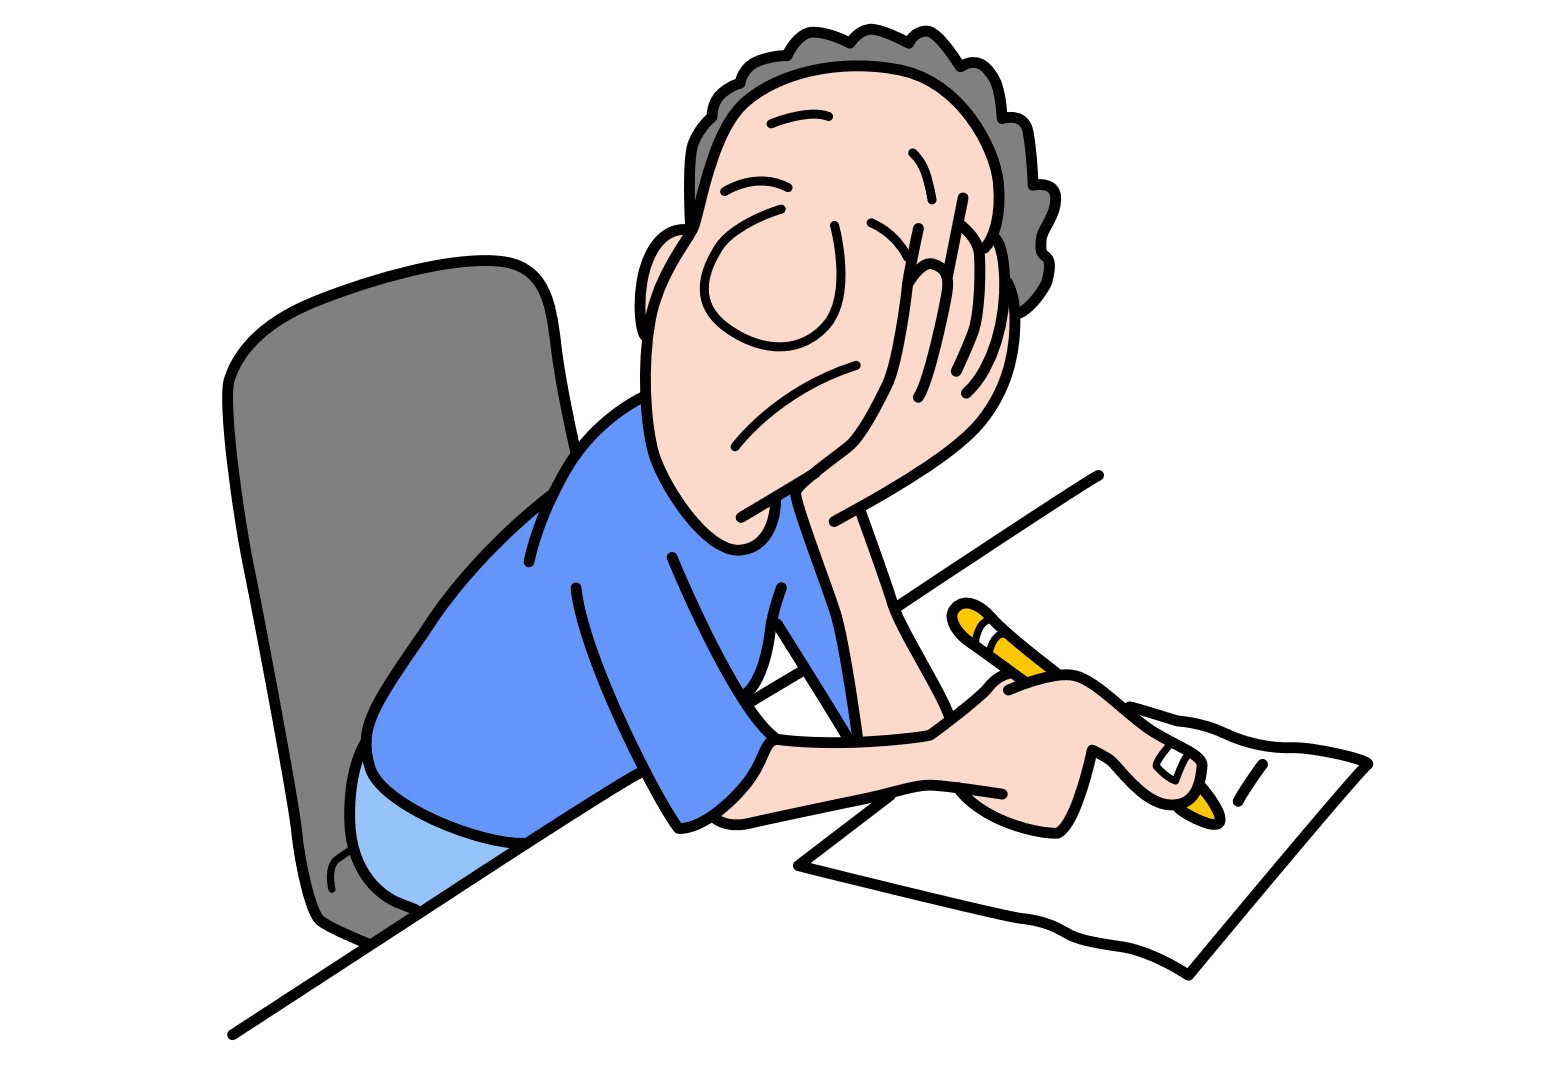

In other words, examinees who spent less than 10% of the USA examinees average time on that item were assigned a value of 1 (rapid guess). Those who spent more than 10% of the USA average time were assigned a value of 0 (non-rapid guess). And when 10% of the average time was more than 10 seconds, 10 seconds became the threshold. 

Finally, those whose values were missing on science item responses were also missing on the rapid guessing responses.

Below is the code for the threshold



In [329]:
# Create the threshold for timing variables

# Create a function that will then be applied to each timing column of the dataframe
def NT10 (col):
    col_len = len(col)
    m = col.mean() # compute the mean of the column
    if m*0.1 < 10000: # if the 10% of the mean is less than 10sec, then 
        threshold = m*0.1 # the threshold is that value
    else: 
        threshold = 10000 # if not, the threshold is 10sec
    result = np.select([(col <= threshold), (col > threshold)], [1, 0], default = np.nan)
    return result 
    
NT10_Thresh = pisa_float1.iloc[:,116:].apply(NT10, axis = 0)     # Apply the function to every column of pisa_float
NT10_Thresh

,CS408Q01TT,CS408Q03TT,CS408Q04TT,CS408Q05TT,CS413Q06TT,CS413Q04TT,CS413Q05TT,CS635Q01TT,CS635Q02TT,CS635Q03TT,...,CS607Q01TT,CS607Q02TT,CS607Q03TT,CS638Q01TT,CS638Q02TT,CS638Q04TT,CS615Q07TT,CS615Q01TT,CS615Q02TT,CS615Q05TT
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [340]:
check1 = pd.concat([NT10_Thresh["CS408Q01TT"], pisa_float1["CS408Q01TT"]], axis = 1)
check1.columns = ["1", "2"]
check1.value_counts(dropna = True)

1    2      
0.0  8504.0     1
     96390.0    1
     92963.0    1
     93016.0    1
     93569.0    1
               ..
     61923.0    1
     62001.0    1
     62208.0    1
     62381.0    1
1.0  8137.0     1
Name: count, Length: 717, dtype: int64

In [342]:
# Create dataset containing Rapid guessing indicator (0 for RG, 1 for NRG)
RG_data = pd.concat([pisa_float1.iloc[:,:115], NT10_Thresh], axis = 1)
RG_data

,CNTSTUID,CS408Q01S,DS408Q03C,CS408Q04S,CS408Q05S,CS413Q06S,CS413Q04S,CS413Q05S,CS635Q01S,CS635Q02S,...,CS607Q01TT,CS607Q02TT,CS607Q03TT,CS638Q01TT,CS638Q02TT,CS638Q04TT,CS615Q07TT,CS615Q01TT,CS615Q02TT,CS615Q05TT
0,84000002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84000003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,84000009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,84000011.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84000015.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,84008120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2197,84008130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2198,84008143.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2199,84008146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that the data is in good shape for the estimation of the null model (the model without the predictors - More info in Mehou et al., 2024) I need one last thing to make the dataset more amenable to manipulation; which is I create dictionary that maps each variable name (as defined by PISA) to a simpler name. 

That dictionary will hold the definition of each variable just in case we need to get back to the meaning of specific variables. And because I'm using two different models for polytomous and dichotomous variable within the bigger IRTree model, I assign the values with that in mind.

In [355]:
len(dichotomous_items)

105

In [356]:
len(polytomous_items)

10

In [353]:
dictionary_items = {}  # empty dictionary 

for count, name in enumerate (dichotomous_items, start = 1): 
    dictionary_items[name] = "I" + str(count) # store in dictionary every dichotomous ITEM and its associated name as "I" + str(#)

for count, name in enumerate (polytomous_items, start = 106): 
    dictionary_items[name] = "I" +str(count) # store in the same dictionary every polytomous ITEM and its associated name as "I" + str(#)




In [483]:
dictionary_rapid_guessing = {}  # empty dictionary 

for count, name in enumerate (NT10_Thresh.iloc[:,:].columns, start = 1): 
    dictionary_rapid_guessing[name] = "RG" + str(count) # store in dictionary every dichotomous ITEM and its associated name as "I" + str(#)
dictionary_rapid_guessing

{'CS408Q01TT': 'RG1',
 'CS408Q03TT': 'RG2',
 'CS408Q04TT': 'RG3',
 'CS408Q05TT': 'RG4',
 'CS413Q06TT': 'RG5',
 'CS413Q04TT': 'RG6',
 'CS413Q05TT': 'RG7',
 'CS635Q01TT': 'RG8',
 'CS635Q02TT': 'RG9',
 'CS635Q03TT': 'RG10',
 'CS635Q04TT': 'RG11',
 'CS635Q05TT': 'RG12',
 'CS604Q02TT': 'RG13',
 'CS604Q04TT': 'RG14',
 'CS625Q01TT': 'RG15',
 'CS625Q02TT': 'RG16',
 'CS625Q03TT': 'RG17',
 'CS626Q01TT': 'RG18',
 'CS626Q02TT': 'RG19',
 'CS626Q03TT': 'RG20',
 'CS425Q03TT': 'RG21',
 'CS425Q05TT': 'RG22',
 'CS425Q02TT': 'RG23',
 'CS425Q04TT': 'RG24',
 'CS438Q01TT': 'RG25',
 'CS438Q02TT': 'RG26',
 'CS438Q03TT': 'RG27',
 'CS608Q01TT': 'RG28',
 'CS608Q02TT': 'RG29',
 'CS608Q03TT': 'RG30',
 'CS608Q04TT': 'RG31',
 'CS643Q03TT': 'RG32',
 'CS643Q01TT': 'RG33',
 'CS643Q02TT': 'RG34',
 'CS643Q04TT': 'RG35',
 'CS643Q05TT': 'RG36',
 'CS610Q01TT': 'RG37',
 'CS610Q02TT': 'RG38',
 'CS466Q01TT': 'RG39',
 'CS466Q07TT': 'RG40',
 'CS256Q01TT': 'RG41',
 'CS326Q01TT': 'RG42',
 'CS326Q02TT': 'RG43',
 'CS326Q03TT': 'RG44

In [354]:
print(dictionary_items) 

{'CS408Q01S': 'I1', 'DS408Q03C': 'I2', 'CS408Q04S': 'I3', 'CS408Q05S': 'I4', 'CS413Q06S': 'I5', 'CS413Q04S': 'I6', 'CS413Q05S': 'I7', 'CS635Q02S': 'I8', 'DS635Q03C': 'I9', 'CS604Q02S': 'I10', 'DS604Q04C': 'I11', 'DS625Q01C': 'I12', 'CS625Q02S': 'I13', 'CS625Q03S': 'I14', 'CS626Q01S': 'I15', 'CS626Q02S': 'I16', 'CS626Q03S': 'I17', 'DS425Q03C': 'I18', 'CS425Q05S': 'I19', 'CS425Q02S': 'I20', 'DS425Q04C': 'I21', 'CS438Q01S': 'I22', 'CS438Q02S': 'I23', 'DS438Q03C': 'I24', 'CS608Q01S': 'I25', 'CS608Q02S': 'I26', 'CS608Q03S': 'I27', 'DS608Q04C': 'I28', 'DS643Q03C': 'I29', 'CS643Q01S': 'I30', 'CS643Q02S': 'I31', 'CS643Q04S': 'I32', 'DS643Q05C': 'I33', 'DS610Q01C': 'I34', 'CS610Q02S': 'I35', 'CS466Q01S': 'I36', 'CS466Q07S': 'I37', 'CS256Q01S': 'I38', 'DS326Q01C': 'I39', 'DS326Q02C': 'I40', 'CS326Q03S': 'I41', 'CS326Q04S': 'I42', 'CS602Q01S': 'I43', 'CS602Q02S': 'I44', 'DS602Q03C': 'I45', 'CS602Q04S': 'I46', 'CS603Q01S': 'I47', 'DS603Q02C': 'I48', 'CS603Q03S': 'I49', 'CS603Q04S': 'I50', 'CS603Q0

In [367]:
pisa_float2 = pisa_float1.loc[:,dichotomous_items + polytomous_items]
pisa_float2.columns = dictionary_items.values()

In [488]:
NT10_Thresh.columns = dictionary_rapid_guessing.values()
NT10_Thresh

,RG1,RG2,RG3,RG4,RG5,RG6,RG7,RG8,RG9,RG10,...,RG106,RG107,RG108,RG109,RG110,RG111,RG112,RG113,RG114,RG115
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [491]:
# Final dataset for the null model (without pred)
pisa_usa_science_null_model = pd.concat ([pisa_float1["CNTSTUID"], pisa_float2, NT10_Thresh], axis = 1)
pisa_usa_science_null_model

,CNTSTUID,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,RG106,RG107,RG108,RG109,RG110,RG111,RG112,RG113,RG114,RG115
0,84000002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,84000003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,84000009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,84000011.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84000015.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,84008120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2197,84008130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2198,84008143.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2199,84008146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [492]:
pisa_usa_science_null_model.to_csv("pisa_usa_science_null_model.csv", index = False)

### **Dataset for nested predictors models: Model 2 and Model 3**

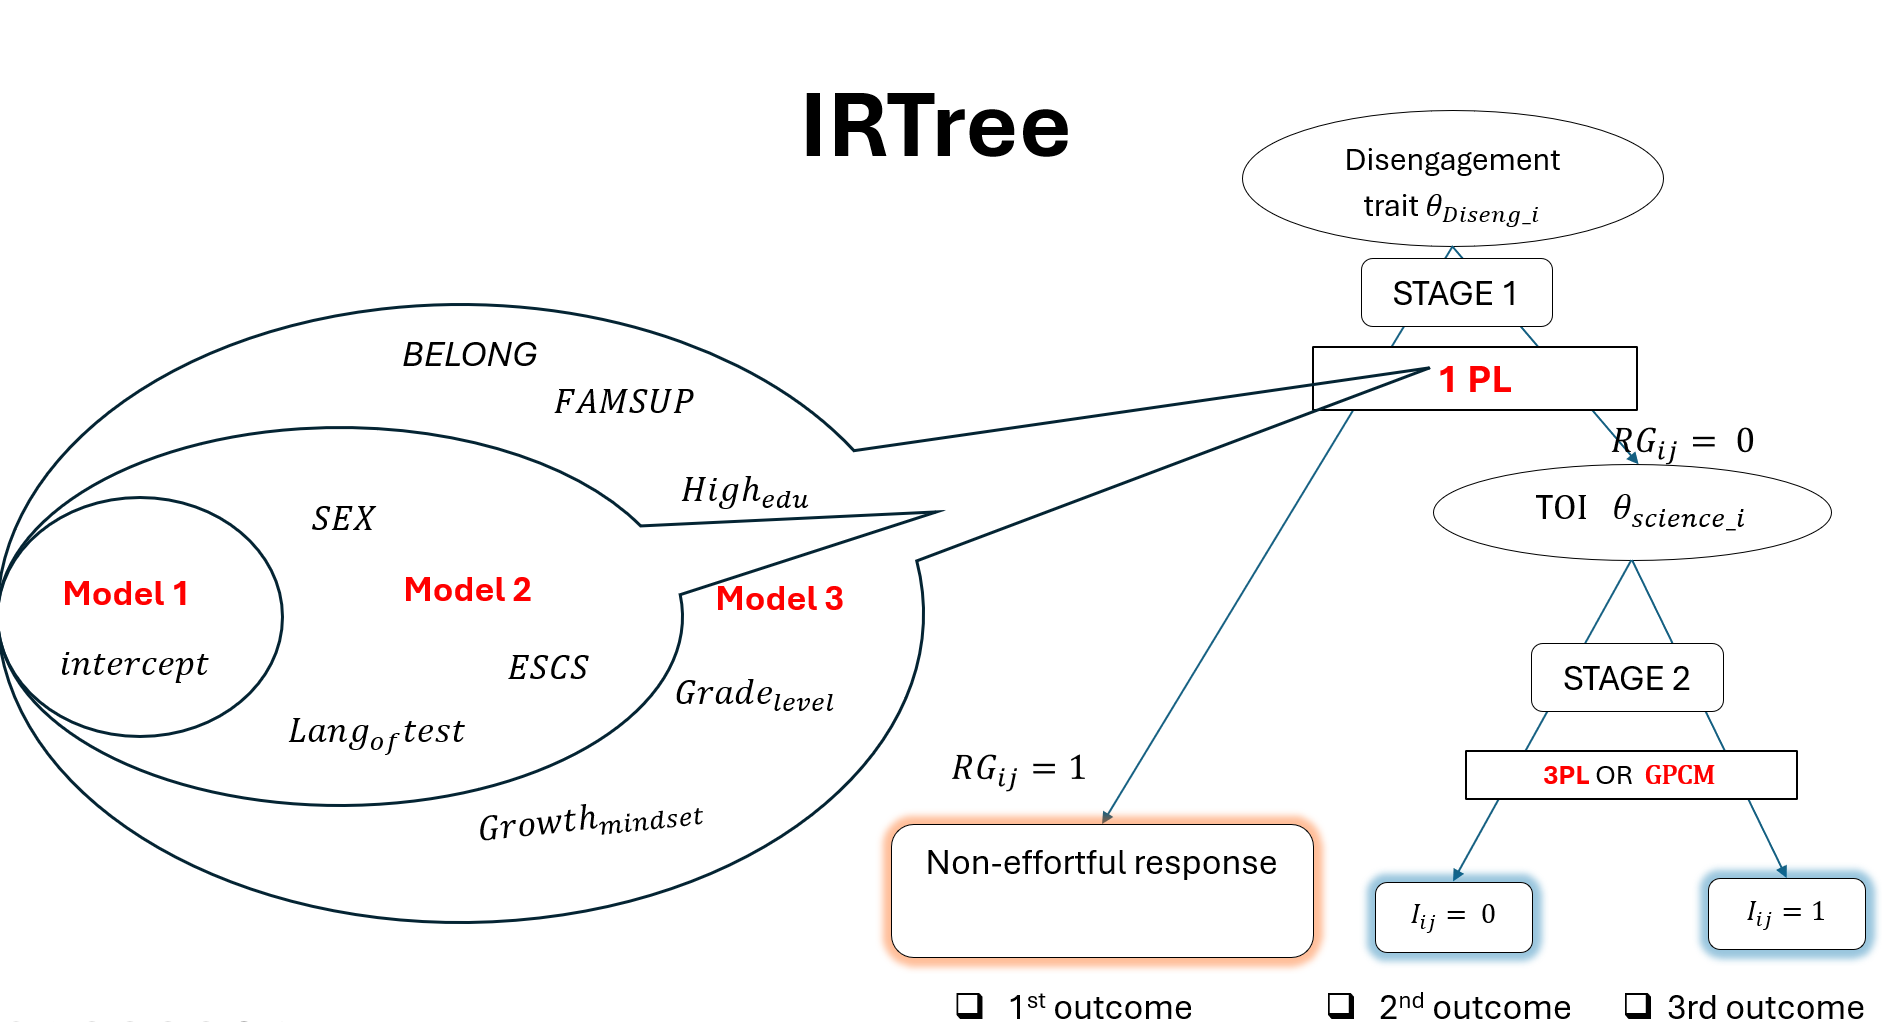

The image above summarized the IRTree model used in this work. As one can see other than the Null or Intercept model, I specified two other models: Three predictors were investigated in Model 2: SEX, ESCS and Lang_of_test (description table below). These predictors have already been found to predict test taking disengagement.


Model 3 contained **additionally** to that first set of predictors, another set of predictors that have not been investigated: Sense_of_belonging, Familly_support, Highest_educational_expectation, Grade_level, Growth_mindset.

| **Variable**                | **Description**                                                                                                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Biological Sex (SEX)**     | This dummy coded variable (Male = 0, Female = 1) was obtained with the PISA question "Are you male or female?". Males are found to have a higher tendency to disengage.           |
| **Language of test (LANG)**  | Indicates if the language spoken at home differs from the test language (language of the test = 0, other language = 1). Predicts disengagement, particularly in science subjects. |
| **Economic Status (SES)**    | PISA ESCS Index measures socioeconomic status with subcomponents like parental education and home possessions. Higher SES correlates with less disengagement.                     |
| **International Grade (IG)** | Students' grade levels (dummy coded). Hypothesized that students in higher grades show more disengagement. Grades 11 and 12 combined due to low sample size.                     |
| **Growth Mindset (GROW)**    | Measured on a scale of agreement with "Your intelligence is something about you that you cannot change very much." Linked to lower disengagement for those with a higher mindset.  |
| **Expected Education (EXP_ED)** | Based on ISCED levels, this variable distinguishes between students expecting a college degree or higher (ISCED 6+) and those expecting less. Higher expectations reduce disengagement. |
| **Sense of Belonging (BELONG)** | A scale measuring school belonging, such as feeling connected or lonely at school. Lower belonging correlates with higher disengagement.                                         |
| **Family Support (FAMSUP)**  | Measured using items on family encouragement (e.g., "My family encourages me to try new things."). Higher family support is associated with lower disengagement.                   |

The code below extract these variables from the gigantic dataset and creates the dataset that will be used to estimate the nested models Model 2 and Model 3

In [494]:
# Same process as done for the cognitive dataset
var_quest = pd.read_csv("variables_quest.csv", names = ["NAME"])  #The file `Variables.csv` contains the list of all vars that I obtained from the codebook

dic_var_quest = {i: "object" for i in var_quest["NAME"] }
len(dic_var_quest)

1278

In [495]:
pisa_quest = dd.read_csv("PISA_QUEST_2022.csv", names = var_quest["NAME"], dtype= dic_var_quest, encoding  = "Latin1")

In [496]:
pisa_quest.head()

,CNT,CNTRYID,CNTSCHID,CNTSTUID,CYC,NatCen,STRATUM,SUBNATIO,REGION,OECD,...,PV3MPRE,PV4MPRE,PV5MPRE,PV6MPRE,PV7MPRE,PV8MPRE,PV9MPRE,PV10MPRE,SENWT,VER_DAT
0,CNT,CNTRYID,CNTSCHID,CNTSTUID,CYC,NatCen,STRATUM,SUBNATIO,REGION,OECD,...,PV3MPRE,PV4MPRE,PV5MPRE,PV6MPRE,PV7MPRE,PV8MPRE,PV9MPRE,PV10MPRE,SENWT,VER_DAT
1,Albania,Albania,800282,800001,08MS,Albania,ALB - stratum 03: Urban / Center / Public,Albania,Albania,No,...,226.25,203.029,219.817,331.017,223.752,305.671,230.156,289.436,0.55561,03MAY23:10:11:25
2,Albania,Albania,800115,800002,08MS,Albania,ALB - stratum 03: Urban / Center / Public,Albania,Albania,No,...,298.644,321.405,320.452,284.836,364.565,304.044,347.626,352.269,0.76431,03MAY23:10:11:25
3,Albania,Albania,800242,800003,08MS,Albania,ALB - stratum 01: Urban / North / Public,Albania,Albania,No,...,383.34,376.019,285.901,289.896,338.469,316.296,324.361,343.351,1.37877,03MAY23:10:11:25
4,Albania,Albania,800245,800005,08MS,Albania,ALB - stratum 08: Rural / Center / Public,Albania,Albania,No,...,264.532,303.422,327.793,165.575,246.156,238.322,275.86,227.466,1.49361,03MAY23:10:11:26


In [497]:
predictors = pd.read_csv("predictors.csv")
predictors

,NAME,LABEL
0,BELONG,Sense of belonging (WLE)
1,BULLIED,Being bullied (WLE)
2,CNTSTUID,Intl. Student ID
3,EFFORT1,How much effort did you put into this test? (a...
4,EFFORT2,How much effort would you have invested? (afte...
5,ESCS,"Index of economic, social and cultural status"
6,EXPECEDU,Highest expected educational level
7,FAMSUP,Family support (WLE)
8,MISSSC,Missing school for more than 3 months
9,REPEAT,Grade repetition


In [498]:
bool = pisa_quest["CNT"] == "United States"
pred_dataset = pisa_quest.loc[bool, predictors["NAME"].tolist()]

In [499]:
# Exportation 
pred_dataset.to_csv("pred_dataset.csv", index=False, single_file=True)

['C:\\Users\\mehoujm\\Downloads\\pred_dataset.csv']

In [500]:
pred_dataset1 = pd.read_csv("pred_dataset.csv") #Importing previously exported csv file
pred_dataset1.head(1)

,BELONG,BULLIED,CNTSTUID,EFFORT1,EFFORT2,ESCS,EXPECEDU,FAMSUP,MISSSC,REPEAT,ST001D01T,ST004D01T,ST022Q01TA,ST263Q02JA,ST263Q04JA
0,-0.338,-1.228,84000002,No Response,No Response,1.2582,ISCED Level 8,0.0488,Never missed school for >3 months,Never repeated,Grade 10,Male,Language of the test,Strongly disagree,Agree


#### Questionnaire data exploration and cleaning

Just as done for the cognitive dataset, I will explore the questionnaire dataset, clean it and prepare the variable for model estimation

In [501]:
# Dropping these variables since they I'm not using them
useful_predictors = pred_dataset1.drop(["EFFORT1", "EFFORT2", "ST263Q04JA", "MISSSC", "REPEAT" ], axis = 1) 
'CNTSTUID', 
useful_predictors = useful_predictors.loc[:, ['CNTSTUID', 'BELONG', 'BULLIED', 'ESCS', 'FAMSUP',
       'ST001D01T', 'ST004D01T', 'ST022Q01TA', 'ST263Q02JA','EXPECEDU']]

useful_predictors

,CNTSTUID,BELONG,BULLIED,ESCS,FAMSUP,ST001D01T,ST004D01T,ST022Q01TA,ST263Q02JA,EXPECEDU
0,84000002,-0.338,-1.228,1.2582,0.0488,Grade 10,Male,Language of the test,Strongly disagree,ISCED Level 8
1,84000003,0.6428,-1.228,0.3488,-0.5726,Grade 10,Male,Language of the test,Disagree,ISCED Level 3.4
2,84000004,-0.3397,-1.228,1.3463,-0.0759,Grade 10,Male,Language of the test,Strongly disagree,ISCED level 7
3,84000005,-0.4867,0.845,-1.3108,-0.3054,Grade 10,Female,Language of the test,Agree,ISCED Level 3.4
4,84000006,2.7562,0.379,-0.9745,-0.896,Grade 11,Female,Language of the test,Disagree,ISCED Level 8
...,...,...,...,...,...,...,...,...,...,...
4547,84008148,-0.9477,0.8703,0.5405,-1.0505,Grade 10,Female,Language of the test,Disagree,ISCED Level 3.4
4548,84008151,-1.2242,0.5381,0.8619,-0.6802,Grade 11,Female,Language of the test,Strongly disagree,ISCED Level 8
4549,84008153,0.3739,-1.228,0.885,0.9978,Grade 10,Female,Language of the test,Agree,ISCED level 7
4550,84008155,-0.4812,-1.228,0.0051,-1.882,Grade 10,Female,Language of the test,Strongly agree,ISCED level 7


In [502]:
# Recode to missing No Response' and 'Missing'
def to_missing(cell):
    if cell in ['No Response', 'Missing']:
        cell = np.nan
        return cell
    else:
        return cell


useful_predictors_cleaned = useful_predictors.map(to_missing)

In [503]:
#Explore the values
for i in useful_predictors_cleaned.columns[1:10]:
    print(useful_predictors_cleaned[i].value_counts(dropna = False))
    print("\n")

BELONG
NaN        479
-0.338     166
-0.3485    158
-0.3261    137
-0.2482    135
          ... 
-0.7706      1
-0.702       1
-0.7765      1
0.4941       1
-0.4812      1
Name: count, Length: 1032, dtype: int64


BULLIED
-1.228     1851
NaN         475
-0.1325     221
-0.267      184
0.2988      129
           ... 
1.7818        1
1.9159        1
1.8815        1
1.1556        1
1.3882        1
Name: count, Length: 675, dtype: int64


ESCS
NaN        210
0.7841       3
0.5845       3
0.6131       3
0.9678       3
          ... 
-0.7027      1
-0.1083      1
-2.3897      1
0.7228       1
1.1252       1
Name: count, Length: 4059, dtype: int64


FAMSUP
NaN        588
1.3432      10
1.4745       8
1.4425       8
1.4752       8
          ... 
-0.6002      1
-1.7839      1
-0.4482      1
0.8692       1
-1.882       1
Name: count, Length: 3152, dtype: int64


ST001D01T
Grade 10    3378
Grade 11     786
Grade 9      380
Grade 12       7
Grade 8        1
Name: count, dtype: int64


ST004D01T
Ma

Now, I'll dummy code the categorical variables. I could use pandas function get dummies. But I want to control which category is assigned to be the reference because I want that category to reflect the least (from previous research) disengagement.

In [504]:
useful_predictors_ready = pd.DataFrame()
def bachelors(cell):
    if cell in ["ISCED Level 2", "ISCED Level 3.4", "ISCED Level 4", "ISCED Level 5"]:
        return 0
    elif cell in ["ISCED Level 6", "ISCED Level 7", "ISCED Level 4", "ISCED Level 8"]:
        return 1
    else:
        return np.nan


useful_predictors_ready["EXPECEDU_BACHELORS"] = useful_predictors_cleaned["EXPECEDU"].apply(bachelors)

In [505]:
def GROW_str_agree(cell):
    if cell == "Strongly agree":
        return 1
    elif pd.isna(cell):
        return np.nan
    else:
        return 0

def GROW_agree(cell):
    if cell == "Agree":
        return 1
    elif cell == pd.isna(cell):
        return np.nan
    else:
        return 0
        
def GROW_disagree(cell):
    if cell == "Disagree":
        return 1
    elif pd.isna(cell):
        return np.nan
    else:
        return 0
        
useful_predictors_ready["Growth_str_agree"] = useful_predictors_cleaned["ST263Q02JA"].apply(GROW_str_agree)
useful_predictors_ready["Growth_agree"] = useful_predictors_cleaned["ST263Q02JA"].apply(GROW_agree)
useful_predictors_ready["Growth_disagree"] = useful_predictors_cleaned["ST263Q02JA"].apply(GROW_disagree)

In [506]:
def LANG (cell):
    if cell == "Other language":
        return 0
    elif cell == "Language of the test":
        return 1
    else:
        return np.nan
useful_predictors_ready["LANG_of_test"] = useful_predictors_cleaned["ST022Q01TA"].apply(LANG)

In [507]:
def GRADE_9 (cell):
    if cell == "Grade 9":
        return 1
    elif pd.isna(cell):
        return np.nan
    else:
        return 0
        
def GRADE_10 (cell):
    if cell == "Grade 10":
        return 1
    elif pd.isna(cell):
        return np.nan
    else:
        return 0

useful_predictors_ready["Grade_9"] = useful_predictors_cleaned["ST001D01T"].apply(GRADE_9)
useful_predictors_ready["Grade_10"] = useful_predictors_cleaned["ST001D01T"].apply(GRADE_10)

In [508]:
def female (cell):
    if cell == "Female":
        return 1
    elif cell == "Male":
        return 0
    else:
        return np.nan
useful_predictors_ready["Female"] = useful_predictors_cleaned["ST004D01T"].apply(female)

In [509]:
useful_predictors_ready.loc[:,["CNTSTUID", "BELONG","BULLIED","ESCS","FAMSUP"]] = useful_predictors_cleaned.iloc[:,:6]

In [510]:
useful_predictors_ready

,EXPECEDU_BACHELORS,Growth_str_agree,Growth_agree,Growth_disagree,LANG_of_test,Grade_9,Grade_10,Female,CNTSTUID,BELONG,BULLIED,ESCS,FAMSUP
0,1.0,0.0,0,0.0,1.0,0,1,0.0,84000002,-0.338,-1.228,1.2582,0.0488
1,0.0,0.0,0,1.0,1.0,0,1,0.0,84000003,0.6428,-1.228,0.3488,-0.5726
2,NaN,0.0,0,0.0,1.0,0,1,0.0,84000004,-0.3397,-1.228,1.3463,-0.0759
3,0.0,0.0,1,0.0,1.0,0,1,1.0,84000005,-0.4867,0.845,-1.3108,-0.3054
4,1.0,0.0,0,1.0,1.0,0,0,1.0,84000006,2.7562,0.379,-0.9745,-0.896
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547,0.0,0.0,0,1.0,1.0,0,1,1.0,84008148,-0.9477,0.8703,0.5405,-1.0505
4548,1.0,0.0,0,0.0,1.0,0,0,1.0,84008151,-1.2242,0.5381,0.8619,-0.6802
4549,NaN,0.0,1,0.0,1.0,0,1,1.0,84008153,0.3739,-1.228,0.885,0.9978
4550,NaN,1.0,0,0.0,1.0,0,1,1.0,84008155,-0.4812,-1.228,0.0051,-1.882


One note before merging with the `null dataset` is that this one has 4552 records because it includes the other examinees from the USA that did not have science forms as explained above. Therefore, when merging, we'll retain records that are in both datasets.

The merging will be done by `CNTSTUID` the unique student identifier

In [511]:
nested_models_dataset = pd.merge(left = pisa_usa_science_null_model, right = useful_predictors_ready, on = "CNTSTUID")
nested_models_dataset

,CNTSTUID,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,Growth_agree,Growth_disagree,LANG_of_test,Grade_9,Grade_10,Female,BELONG,BULLIED,ESCS,FAMSUP
0,84000002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.0,1.0,0,1,0.0,-0.338,-1.228,1.2582,0.0488
1,84000003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1.0,1.0,0,1,0.0,0.6428,-1.228,0.3488,-0.5726
2,84000009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1.0,1.0,0,1,0.0,-0.9024,1.4747,0.801,-2.8015
3,84000011.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0.0,1.0,0,1,1.0,-0.3485,-1.228,0.7473,-0.0084
4,84000015.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1,0.0,1.0,0,1,0.0,0.3576,1.3249,0.8877,-0.1398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,84008120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0.0,1.0,0,1,0.0,-0.9598,-0.2016,1.2658,0.2928
2197,84008130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.0,1.0,0,1,1.0,-0.7074,0.2988,0.7243,-0.1329
2198,84008143.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0,NaN,NaN,0,1,1.0,NaN,NaN,NaN,NaN
2199,84008146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.0,1.0,0,1,0.0,-1.1289,0.6017,0.0426,-0.1561


In [512]:
nested_models_dataset.to_csv("nested_models_dataset.csv", index = False)
useful_predictors_ready.to_csv("useful_predictors_ready.csv", index = False)


### **Descriptives**

#### Exploration of rapid guessing at the item level

In [513]:
# Percentage of rapid guessing at the item level
rg = nested_models_dataset.loc[:, "RG1":"RG115"]    
R = (rg.sum(axis = 0)/len(rg) * 100).sort_values()

RTFs = 100 - R # Calculate the percentage of students *not* rapidly guessing per item 

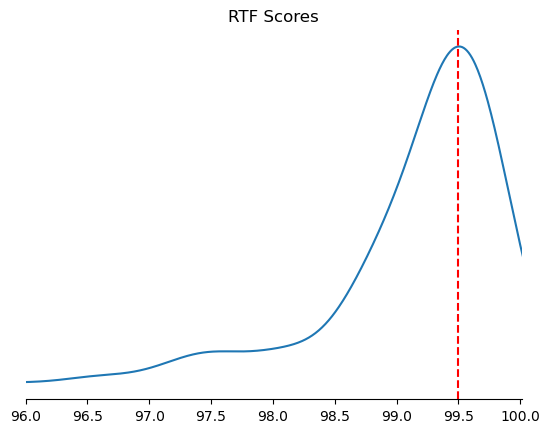

In [516]:
# Density plot of RTF Scores
ax = RTFs.plot(kind = "kde", title = "RTF Scores")
plt.axvline(x=99.5, color='red', linestyle='--', label='Vertical Line at x=2') 
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_xlim(96, 100.01)

plt.show()

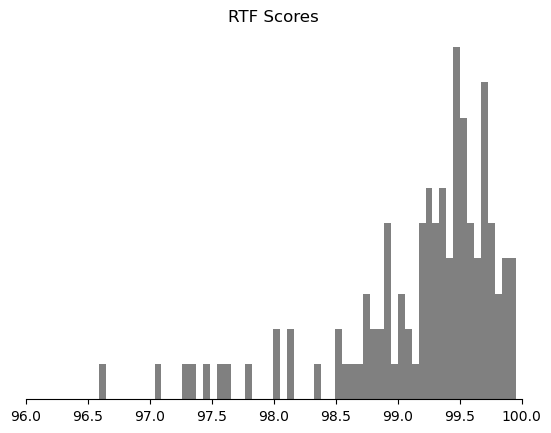

In [517]:
# Density plot of RTF Scores
ax = RTFs.plot(kind = "hist", bins =60, title = "RTF Scores", color = "grey")
plt.axvline(x=0.5, color='grey', linestyle='--', label='Vertical Line at x=2') 
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_xlim(96, 100)
plt.show()

#### Rapid guessing at the examinee level

In [519]:
RTEs = (115 - rg.sum(axis = 1))

<Axes: ylabel='Frequency'>

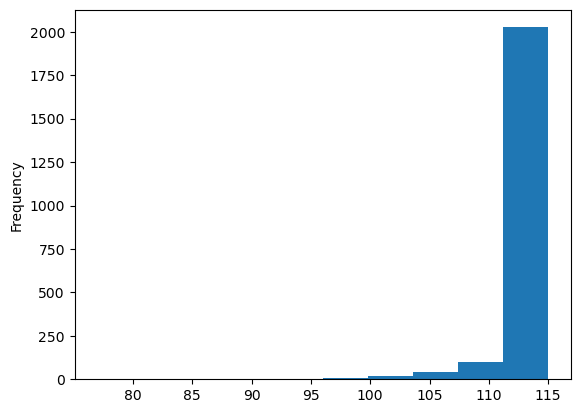

In [520]:
RTEs.plot(kind = "hist")

In [521]:
freq_RTE = RTEs.value_counts()
freq_RTE
RTEs = pd.DataFrame()
RTEs["Items_NOT_RGed"] = freq_RTE.index
RTEs.index = freq_RTE.index

In [523]:
RTEs["freq"] = freq_RTE
RTEs["perc in %"] = (freq_RTE / 2201)*100

In [524]:
RTEs.index = range(0,28)
RTEs.head(10)

,Items_NOT_RGed,freq,perc in %
0,115.0,1683,76.465243
1,114.0,183,8.314403
2,113.0,110,4.997728
3,112.0,50,2.271695
4,110.0,28,1.272149
5,111.0,28,1.272149
6,109.0,25,1.135847
7,108.0,18,0.817810
8,107.0,18,0.817810
9,106.0,12,0.545207


In [525]:
# Percent of examinees who rapid guessed on at least one of the 115 science items
y = []
for i in range(1,7):
    y.append(RTEs.loc[RTEs["Items_NOT_RGed"] <= 115 - i, "perc in %"].sum())
y = [76.465243] + y

In [527]:
to_plot = RTEs["perc in %"][:4] 

In [529]:
to_plot[4] = RTEs.loc[RTEs["Items_NOT_RGed"] <= 115 - 4, "perc in %"].sum()
x = ["No RG", "One RG", "Two RGs", "Three RGs", "Four RGs or more"]

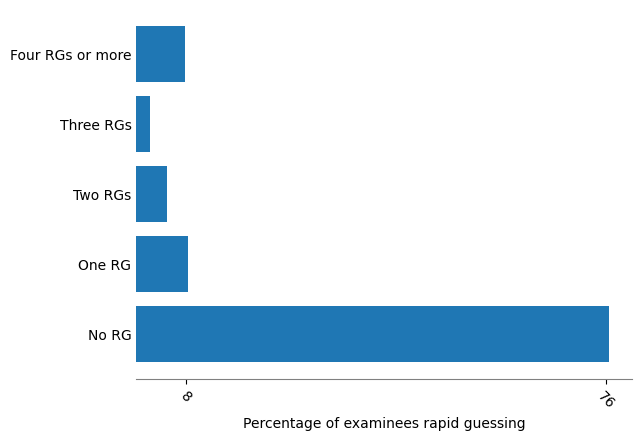

In [530]:
plt.barh(x,to_plot)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
        
plt.gca().spines['bottom'].set_visible(True)

# Optionally, you can also hide the ticks
plt.xticks([76, 8],  rotation=-45, fontsize=10)
plt.gca().yaxis.set_tick_params(length=0)
plt.gca().spines['bottom'].set_color('grey')
plt.xlabel("Percentage of examinees rapid guessing")
plt.show()

In [531]:
# Percent of examinees who rapid guessed on at least two of the 115 science items
RTEs.loc[RTEs["Items_NOT_RGed"] <= 113, "perc in %"].sum()

15.22035438437074

In [532]:
# Percent of examinees who rapid guessed on at least three of the 115 science items
RTEs.loc[RTEs["Items_NOT_RGed"] <= 112, "perc in %"].sum()

10.222626079054974

<Axes: >

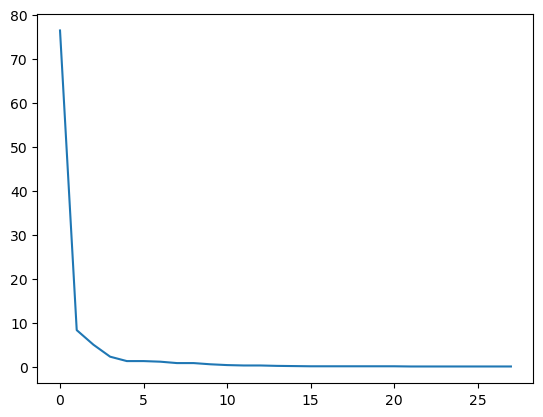

In [533]:
RTEs["perc in %"].plot(kind = "line")

#### Examinee level factors Descriptives

In [536]:
nested_models_dataset.head()

,CNTSTUID,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,Growth_agree,Growth_disagree,LANG_of_test,Grade_9,Grade_10,Female,BELONG,BULLIED,ESCS,FAMSUP
0,84000002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.0,1.0,0,1,0.0,-0.338,-1.228,1.2582,0.0488
1,84000003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1.0,1.0,0,1,0.0,0.6428,-1.228,0.3488,-0.5726
2,84000009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1.0,1.0,0,1,0.0,-0.9024,1.4747,0.801,-2.8015
3,84000011.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0.0,1.0,0,1,1.0,-0.3485,-1.228,0.7473,-0.0084
4,84000015.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1,0.0,1.0,0,1,0.0,0.3576,1.3249,0.8877,-0.1398


In [537]:
vars = ["Female","LANG_of_test","ESCS", "Growth_disagree", "Growth_agree", 
                                      "Growth_str_agree", "Grade_10", "Grade_9", "EXPECEDU_BACHELORS", "BELONG", "FAMSUP", "BULLIED"]
continuous_vars = ["BELONG","FAMSUP", "BULLIED", "ESCS"]

categorical_vars =["Female","LANG_of_test","Growth_disagree", "Growth_agree", "Growth_str_agree", "Grade_10", "Grade_9"]

In [538]:
###### Mean and Sd for continuous vars

In [546]:
M = nested_models_dataset[continuous_vars].astype(float).mean(axis = 0)
STD = nested_models_dataset[continuous_vars].astype(float).std(axis = 0)

[M.to_numpy()[np.newaxis, :], STD.to_numpy()[np.newaxis, :]]
pd.DataFrame([M.to_list(), STD.to_list()] , columns = [M.index])

,BELONG,FAMSUP,BULLIED,ESCS
0,-0.268054,0.087753,-0.307402,0.056203
1,0.855486,0.961762,0.989339,0.982265


In [548]:
for i in nested_models_dataset.columns[:10]:
    print(nested_models_dataset[i].value_counts(dropna = False) )

CNTSTUID
84000002.0    1
84005399.0    1
84005375.0    1
84005376.0    1
84005382.0    1
             ..
84002737.0    1
84002735.0    1
84002726.0    1
84002724.0    1
84008148.0    1
Name: count, Length: 2201, dtype: int64
I1
NaN    1491
1.0     370
0.0     340
Name: count, dtype: int64
I2
NaN    1516
0.0     523
1.0     162
Name: count, dtype: int64
I3
NaN    1496
1.0     420
0.0     285
Name: count, dtype: int64
I4
NaN    1497
0.0     533
1.0     171
Name: count, dtype: int64
I5
NaN    1512
0.0     435
1.0     254
Name: count, dtype: int64
I6
NaN    1503
0.0     407
1.0     291
Name: count, dtype: int64
I7
NaN    1509
1.0     442
0.0     250
Name: count, dtype: int64
I8
NaN    1519
1.0     496
0.0     186
Name: count, dtype: int64
I9
NaN    1519
0.0     352
1.0     330
Name: count, dtype: int64


1109 females and 1091 Males examinees

866 of the examinees expected their highest educational status to be bachelors' degree or higher (ISCED 6 and higher)

629 of the examinees expected their highest educational status to be lower than bachelors' degree (ISCED 5 and lower)


#### Descriptives of items parameters estimated with proc MCMC

In [553]:
# Read SAS PROC MCMC dataset output in here
import sas7bdat
# Read the SAS dataset
output = pd.read_sas(r"C:\Users\mehoujm\OneDrive - James Madison University (1)\My project\Results SAS\data_post.sas7bdat")

In [554]:
output.head()

,Iteration,b1_1,b1_2,b1_3,b1_4,b1_5,b1_6,b1_7,b1_8,b1_9,...,TOI_2199,DISENG_2199,TOI_2200,DISENG_2200,TOI_2201,DISENG_2201,LogPrior,LogReff,LogLike,LogPost
0,10001.0,2.326100,2.432793,2.761683,2.650735,2.557101,2.509360,2.815086,2.933166,2.324205,...,-0.884812,0.762194,-0.019289,-0.856126,0.895736,0.070281,-631.328405,-5657.891053,-46081.085741,-52370.305199
1,10006.0,2.326100,2.432793,2.798451,2.650735,2.557101,2.979604,2.753798,3.036880,2.324205,...,-0.686960,-0.179656,0.474541,-1.115945,0.979416,-0.428942,-630.796995,-5603.809267,-46044.646705,-52279.252966
2,10011.0,2.326100,2.404076,2.798451,2.609939,2.617740,2.548842,2.753798,3.065286,2.593645,...,-0.686960,-0.179656,0.245236,-0.672857,1.372185,-0.866852,-629.626282,-5583.764789,-46032.911590,-52246.302660
3,10016.0,2.308747,2.296578,2.798451,2.528803,2.617740,2.548842,2.753798,3.065286,2.695064,...,0.207436,0.501880,0.245236,-0.672857,1.262066,-0.763257,-625.470981,-5625.876203,-46094.575909,-52345.923093
4,10021.0,2.499679,2.471735,2.971983,2.528803,2.593909,2.690305,2.776973,3.192231,2.174165,...,0.207436,0.501880,0.100502,-0.987286,1.262066,-0.763257,-627.874248,-5594.320197,-46174.486651,-52396.681097


In [556]:
import re
Diseng_var = []

for i in output.columns:
    if re.match(r"DISENG[\S]+", i):
        Diseng_var.append(i)


In [557]:
Diseng_means = output[Diseng_var].mean(axis = 0)

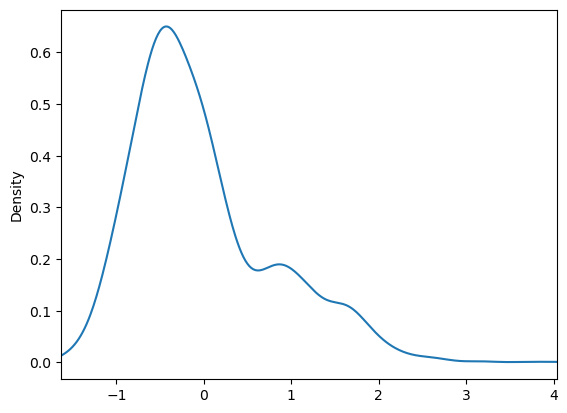

In [558]:
ax = Diseng_means.plot(kind = "kde")
ax.set_xlim (-1.630307, 4.044076)
plt.show()


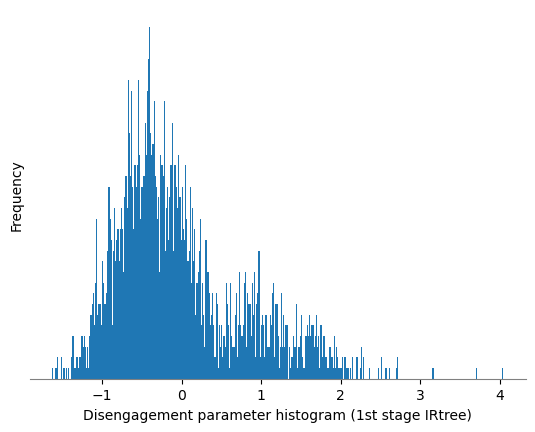

In [559]:
ax = Diseng_means.plot(kind = "hist", bins = 400)

for spine in plt.gca().spines.values():
    spine.set_visible(False)
        
plt.gca().spines['bottom'].set_visible(True)

# Optionally, you can also hide the ticks
plt.gca().yaxis.set_tick_params(length=0)
plt.gca().spines['bottom'].set_color('grey')
plt.xlabel("Disengagement parameter histogram (1st stage IRtree)")
plt.yticks([])
plt.show()

In [560]:
b1_params = []

for i in output.columns:
    if re.match(r"b1[\S]+", i):
        b1_params.append(i)

In [562]:
import seaborn as sns

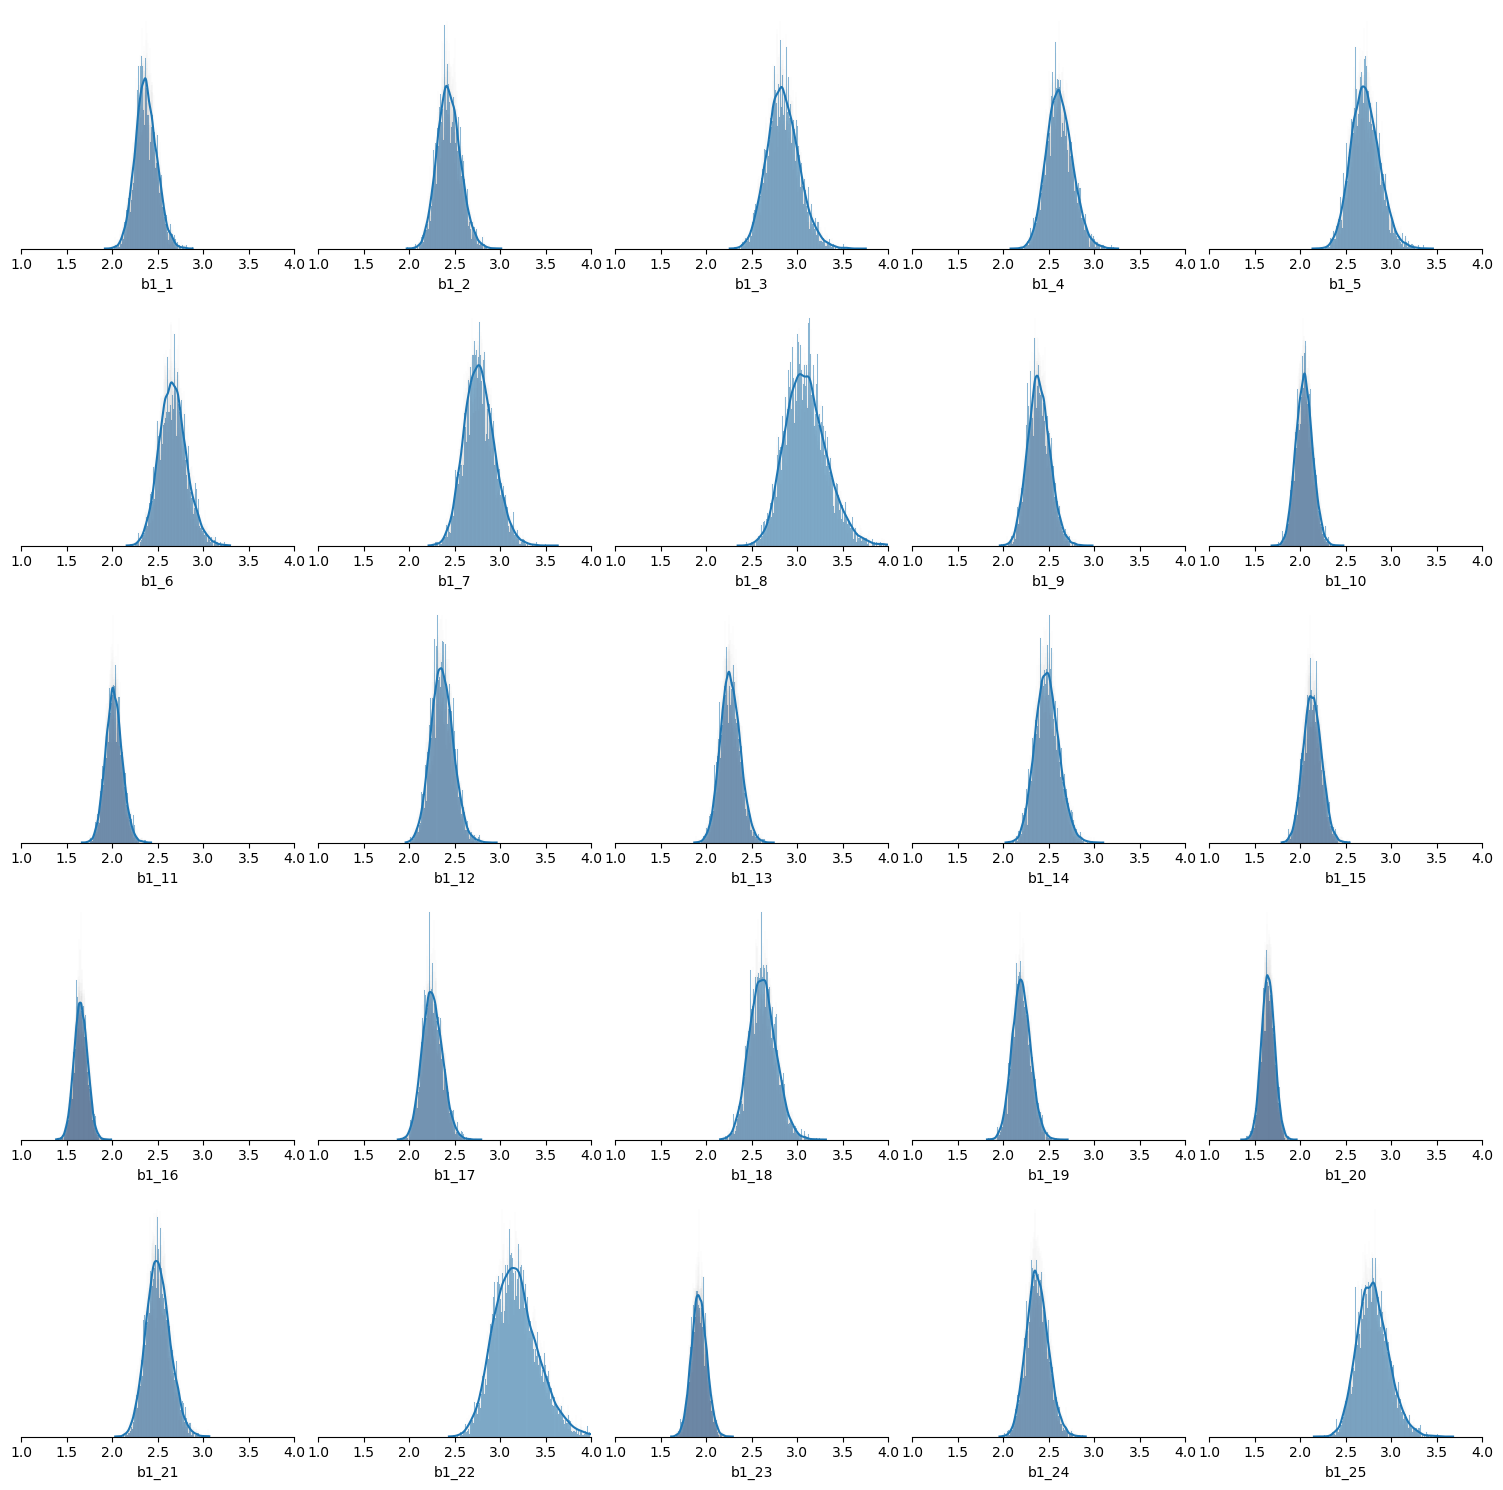

In [563]:
fig, ax = plt.subplots(5,5, figsize = (15,15))

count = 0

for i in range(0,5):
    for j in range(0,5):
        sns.histplot(output[b1_params[count]], kde=True, bins=1000, ax = ax [i,j])
        ax[i, j].set_xlim(1, 4)
        for p in ["top", "left", "right"]:
            ax[i,j].spines[p].set_visible(False)
        ax[i,j].get_xaxis().set_visible(True)
        ax[i,j].get_yaxis().set_visible(False)
        count += 1 


plt.tight_layout()
plt.show()
